# 📚 Проект: Books Recommendation System

**Цель проекта:**
Создать рекомендательную систему для книг, которая поможет пользователям находить интересные произведения на основе их предпочтений и информации о книгах. Система должна использовать как коллаборативную фильтрацию, так и контентные характеристики книг.

Этот проект строит рекомендательную систему книг на основе трех датасетов: Users, Ratings и Books.

**Что сделано:**
- Загрузка и подготовка данных.
- Анализ данных (**EDA**).
- Подготовка выборок.
- Подготовка и обучение модели (**KNN** на косинусной метрике, **SVD** и **Cosine Similarity**).
- Реализация функции получения рекомендаций:
    - по названию книги (item-based)
    - по пользователю (user-based)
    - по автору.
- Оценка качества модели с использованием метрик **Precision@k, Recall@k,F1-Score@10 MMAP, AP, MRR.**

**Использованные библиотеки:** pandas, numpy, sklearn, scipy, matplotlib и seaborn.

### **1. Загрузка и подготовка данных**

In [2]:
# Импорт необходимый библиотек 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from IPython.display import HTML, display
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [4]:
# Загрузка датасетов
df_users = pd.read_csv('Users.csv', low_memory=False)
df_ratings = pd.read_csv('Ratings.csv', low_memory=False)
df_books = pd.read_csv('Books.csv', low_memory=False)

# Вывод размеров датафреймов
print('\nРазмер датасета пользователей (df_users):', df_users.shape)
print('\nРазмер датасета рейтингов (df_ratings):', df_ratings.shape)
print('\nРазмер датасета книг (df_books):', df_books.shape)



Размер датасета пользователей (df_users): (278858, 3)

Размер датасета рейтингов (df_ratings): (1149780, 3)

Размер датасета книг (df_books): (271360, 8)


In [6]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [10]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [12]:
# Удаление ненужных столбцов
df_books = df_books.drop(columns=['Image-URL-M', 'Image-URL-S'], axis=1)
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [14]:
# Изменение названий столбцов (df_books)
df_books = df_books.rename(columns={'ISBN': 'isbn', 'Book-Title': 'book_title', 'Book-Author': 'book_author', 'Year-Of-Publication': 'year_of_publication', 'Publisher': 'publisher', 'Image-URL-L': 'image_url_l'})
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [16]:
# Изменение названий столбцов (df_ratings)
df_ratings = df_ratings.rename(columns={'User-ID': 'user_id', 'ISBN': 'isbn', 'Book-Rating': 'book_rating'})
df_ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [18]:
# Типы данных

In [20]:
df_ratings.dtypes

user_id         int64
isbn           object
book_rating     int64
dtype: object

In [22]:
df_books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
image_url_l            object
dtype: object

In [24]:
# Проверка пропущенных значений (NA)

In [26]:
df_ratings.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [28]:
df_books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
image_url_l            3
dtype: int64

In [30]:
# Удаление строк с пропущенными значениями в столбцах
df_books = df_books.dropna(subset=['book_author', 'publisher', 'image_url_l'])
df_books.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
image_url_l            0
dtype: int64

### **2. Анализ данных (EDA)**

In [33]:
# Описательная статистика
df_ratings.describe().round(1)

,user_id,book_rating
count,1149780.0,1149780.0
mean,140386.4,2.9
std,80562.3,3.9
min,2.0,0.0
25%,70345.0,0.0
50%,141010.0,0.0
75%,211028.0,7.0
max,278854.0,10.0


In [35]:
# Объединение датасетов
df_merged = pd.merge(df_ratings, df_books, on='isbn')
df_merged.head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,image_url_l
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [36]:
df_merged.isna().sum()

user_id                0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
image_url_l            0
dtype: int64

In [38]:
# Размерность данных:
print("Количество строк в датасете: {}".format(df_merged.shape[0]))
print("Количество столбцов в датасете: {}".format(df_merged.shape[1]))

Количество строк в датасете: 1031129
Количество столбцов в датасете: 8


In [41]:
# Визуализация графиков

In [43]:
# Топ-10 самых популярных книг

In [45]:
# Группировка по названию книги и подсчёт количества оценок
book_counts = (
    df_merged.groupby('book_title')['book_rating']
    .count()
    .sort_values(ascending=False)
)
popular_books = book_counts.reset_index()
popular_books.columns = ['book_title', 'book_rating']

top_10_books = popular_books.head(10)
top_10_books

,book_title,book_rating
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828
5,Bridget Jones's Diary,815
6,The Secret Life of Bees,774
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,740
8,The Red Tent (Bestselling Backlist),723
9,Angels &amp; Demons,670


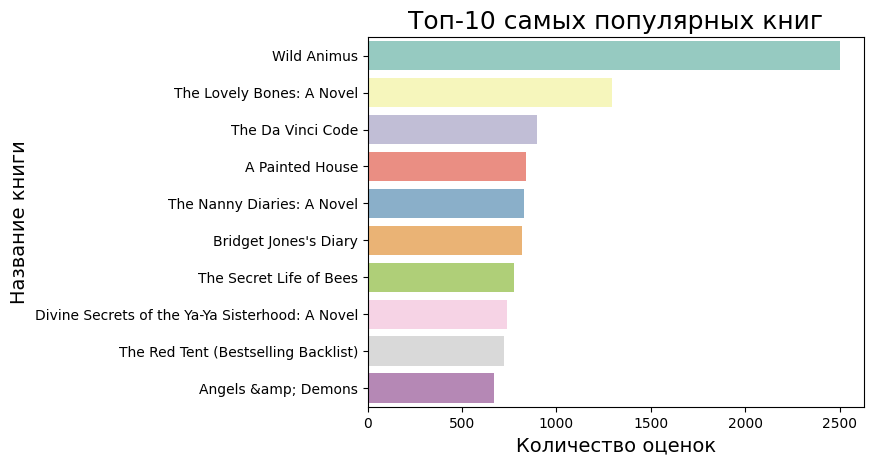

In [47]:
# Построение графика
sns.barplot(x='book_rating', y='book_title', data=top_10_books, palette='Set3')

plt.xlabel('Количество оценок', fontsize=14)
plt.ylabel('Название книги', fontsize=14)
plt.title('Топ-10 самых популярных книг', fontsize=18)
plt.show()


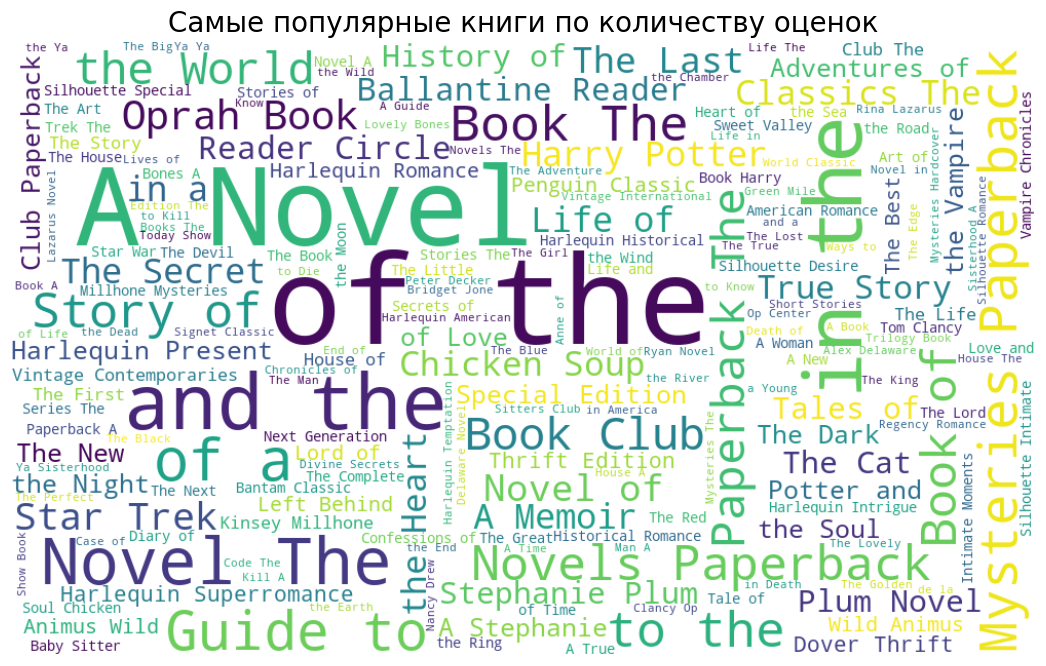

In [48]:
# Создание строки, где каждое название книги повторяется по количеству оценок
book_string = " ".join((title + " ") * count for title, count in book_counts.items())

# Убираем стоп-слова и создаём wordcloud
custom_stopwords = set(STOPWORDS) - {"the", "a", "and", "in", "is", "of", "to"}

# Генерация облака слов
wc = WordCloud(
    width=1000,
    height=600,
    max_font_size=120,
    stopwords=custom_stopwords,
    background_color='white'
).generate(book_string)

# Визуализация
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Самые популярные книги по количеству оценок', fontsize=20)
plt.show()


In [50]:
# Топ-10 авторов 

In [51]:
# Топ-10 авторов по количеству оценок
top_authors = (
    df_merged.groupby('book_author')['book_rating']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
top_authors

,book_author,book_rating
0,Stephen King,10053
1,Nora Roberts,8429
2,John Grisham,6010
3,James Patterson,5845
4,Mary Higgins Clark,4777
5,Dean R. Koontz,4313
6,Tom Clancy,4036
7,Danielle Steel,3726
8,Sue Grafton,3457
9,Janet Evanovich,3350


In [52]:
# Группируем по автору и считаем количество оценок
author_counts = (
    df_merged.groupby('book_author')['book_rating']
    .count()
    .sort_values(ascending=False)
)

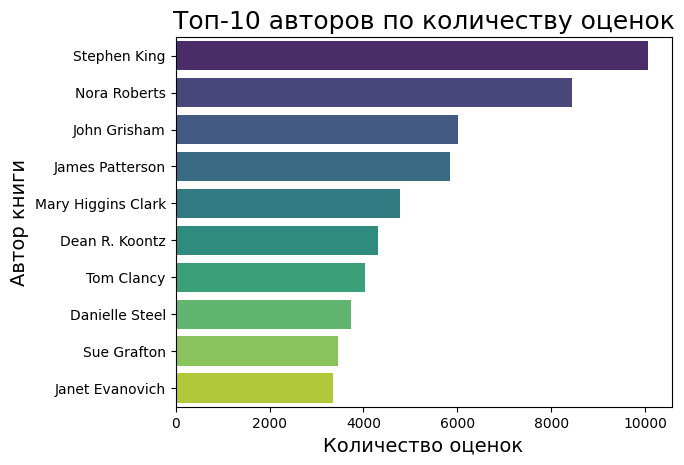

In [53]:
# Построение графика
sns.barplot(x='book_rating', y='book_author', data=top_authors, palette='viridis')

plt.xlabel('Количество оценок', fontsize=14)
plt.ylabel('Автор книги', fontsize=14)
plt.title('Топ-10 авторов по количеству оценок', fontsize=18)
plt.show()

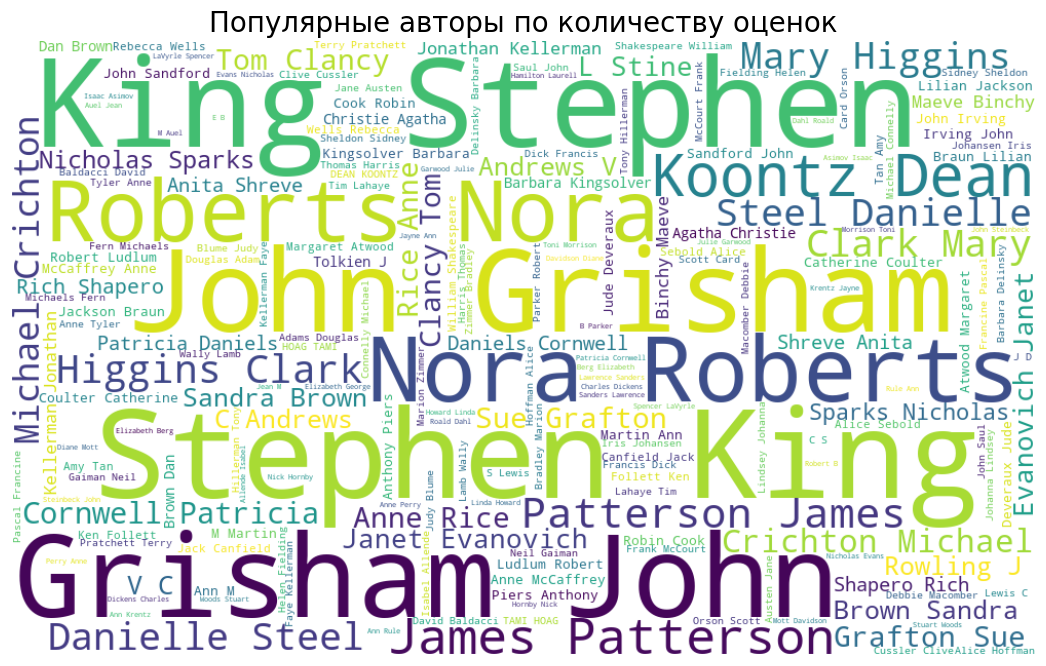

In [54]:
# Создаём строку, где имя каждого автора повторяется по количеству его оценок
author_string = " ".join((author + " ") * count for author, count in author_counts.items())

# Стоп-слова (можно оставить стандартные)
stop_words = set(STOPWORDS)

# Генерация облака слов
wc = WordCloud(
    width=1000,
    height=600,
    max_font_size=120,
    stopwords=stop_words,
    background_color='white'
).generate(author_string)

# Визуализация
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Популярные авторы по количеству оценок', fontsize=20)
plt.show()


In [55]:
# Топ-10 самых активных пользователей

In [56]:
# Считаем количество оценок, которые поставил каждый пользователь
df_counts = df_merged['user_id'].value_counts().reset_index()

# Переименовываем колонки для удобства
df_counts.columns = ['user_id', 'counts']

# Показываем топ-10 самых активных пользователей
df_counts.head(10)


,user_id,counts
0,11676,11144
1,198711,6456
2,153662,5814
3,98391,5777
4,35859,5646
5,212898,4289
6,278418,3996
7,76352,3329
8,110973,2971
9,235105,2943


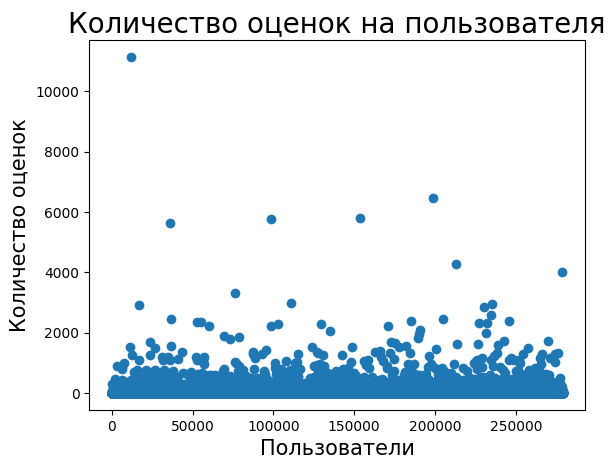

In [57]:
# Строим диаграмму рассеяния
plt.scatter(x=df_counts['user_id'], y=df_counts['counts'])

plt.title('Количество оценок на пользователя', fontsize=20)
plt.xlabel('Пользователи', fontsize=15)
plt.ylabel('Количество оценок', fontsize=15)
plt.show()


### **3. Подготовка выборок**

In [78]:
# Объединение и фильтрация данных
df2 = pd.merge(df_merged, df_counts, on='user_id')
df2_filtered = df2[df2['counts'] > 999].copy()
df2_filtered.drop_duplicates(['user_id','book_title'], inplace=True)
df2_filtered.head()

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,image_url_l,counts
654,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,1690
655,23768,0446520802,6,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,1690
656,23768,038550120X,0,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,1690
657,23768,0425115801,0,Lightning,Dean R. Koontz,1996,Berkley Publishing Group,http://images.amazon.com/images/P/0425115801.0...,1690
658,23768,055356451X,0,Night Sins,TAMI HOAG,1995,Bantam,http://images.amazon.com/images/P/055356451X.0...,1690


In [79]:
# Разделение на train/test
from sklearn.model_selection import train_test_split
train_df2, test_df2 = train_test_split(df2_filtered, test_size=0.2, random_state=42, stratify=df2_filtered['user_id'])

In [82]:
# Топ-1000 популярных книг # Поскольку функция cosine_similarity требует много памяти, я оставил в датасете только 1000 самых популярных книг
top_books = (
    df2_filtered.groupby('book_title')['book_rating']
    .count()
    .sort_values(ascending=False)
    .head(1000)
    .index
)
df_sampled = df2_filtered[df2_filtered['book_title'].isin(top_books)].reset_index(drop=True)
df_sampled.head()


,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,image_url_l,counts
0,23768,0446520802,6,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,1690
1,23768,038550120X,0,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,1690
2,23768,0425115801,0,Lightning,Dean R. Koontz,1996,Berkley Publishing Group,http://images.amazon.com/images/P/0425115801.0...,1690
3,23768,055356451X,0,Night Sins,TAMI HOAG,1995,Bantam,http://images.amazon.com/images/P/055356451X.0...,1690
4,23768,0440498058,0,A Wrinkle In Time,MADELEINE L'ENGLE,1998,Yearling,http://images.amazon.com/images/P/0440498058.0...,1690


In [84]:
# Разделение на train/test для cosine_similarity
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=42, stratify=df_sampled['user_id'])

In [86]:
# Подготовка матрицы книги-пользователи
books_pivot = train_df.pivot_table(columns='user_id', index='book_title', values='book_rating')
books_pivot.head()

user_id,11601,11676,12538,16634,16795,23768,23902,26544,31315,31556,...,254465,257204,265115,266226,269566,271284,274061,274308,275970,278418
book_title,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,10.0,NaN,NaN,9.0,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010: Odyssey Two,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
204 Rosewood Lane,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,10.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [88]:
# Заполнение пропущенных значений нулями
books_pivot.fillna(0, inplace=True)
books_pivot.head()

user_id,11601,11676,12538,16634,16795,23768,23902,26544,31315,31556,...,254465,257204,265115,266226,269566,271284,274061,274308,275970,278418
book_title,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,10.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# Создание разреженной матрицы
books_sparse = csr_matrix(books_pivot.values)

### **4. Подготовка и обучение модели**

In [167]:
# Обучение модели KNN на косинусной метрике

In [169]:
# Создание матрицы "книга — пользователь"
books_pivot_knn = train_df2.pivot_table(index='book_title', columns='user_id', values='book_rating')

# Заполнение пропущенных значений нулями
books_pivot_knn.fillna(0, inplace=True)

# Создание разреженной матрицы
books_sparse_knn = csr_matrix(books_pivot_knn.values)

# Обучение модели KNN на косинусной метрике
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(books_sparse_knn)


NearestNeighbors(algorithm='brute', metric='cosine')

In [171]:
# Рекомендации похожие книги (item-based)
def get_similar_books(book_title, n_neighbors=5):
    if book_title not in books_pivot_knn.index:
        print(f"Книга '{book_title}' не найдена в данных.")
        return

    book_idx = books_pivot_knn.index.get_loc(book_title)
    distances, suggestion = knn.kneighbors(books_pivot_knn.iloc[book_idx, :].values.reshape(1, -1), n_neighbors=n_neighbors + 1)

    print(f"\n📖 Книги, похожие на: '{book_title}':\n")
    for i in range(1, len(suggestion[0])):
        similar_book = books_pivot_knn.index[suggestion[0][i]]
        print(f"{i}. {similar_book} (расстояние: {distances[0][i]:.4f})")


In [173]:
get_similar_books("The Da Vinci Code", n_neighbors=5)


📖 Книги, похожие на: 'The Da Vinci Code':

1. The Jester (расстояние: 0.2821)
2. Life of Pi (расстояние: 0.2892)
3. Ice (Shooting Stars) (расстояние: 0.3072)
4. Mysteries of the Unexplained (расстояние: 0.3092)
5. Back When We Were Grownups: A Novel (расстояние: 0.3303)


In [177]:
# Оценки метрики 
# Метрика: Precision@K
def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / k

# Метрика: Recall@K
def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / len(relevant) if relevant else 0

# Метрика: F1@K
def f1_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Метрика: MRR (Mean Reciprocal Rank)
def reciprocal_rank(recommended, relevant):
    for i, rec in enumerate(recommended):
        if rec in relevant:
            return 1 / (i + 1)
    return 0

# Метрика: MAP@K
def average_precision_at_k(recommended, relevant, k):
    score = 0.0
    hits = 0
    for i in range(min(k, len(recommended))):
        if recommended[i] in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0

# Общая функция оценки всех метрик
def evaluate_all_metrics(k=5, rating_threshold=7):
    users = train_df2['user_id'].unique()
    
    precision_list = []
    recall_list = []
    f1_list = []
    mrr_list = []
    map_list = []

    for user_id in users:
        user_data = train_df2[train_df2['user_id'] == user_id]
        relevant_books = user_data[user_data['book_rating'] >= rating_threshold]['book_title'].tolist()

        if not relevant_books:
            continue

        recommended_books = []
        for book in relevant_books:
            similar = get_top_k_similar_books(book, k)
            recommended_books.extend(similar)

        # Удаляем дубликаты
        recommended_books = list(dict.fromkeys(recommended_books))

        if not recommended_books:
            continue

        prec = precision_at_k(recommended_books, relevant_books, k)
        rec = recall_at_k(recommended_books, relevant_books, k)
        f1 = f1_at_k(prec, rec)
        mrr = reciprocal_rank(recommended_books, relevant_books)
        ap = average_precision_at_k(recommended_books, relevant_books, k)

        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)
        mrr_list.append(mrr)
        map_list.append(ap)

    print(f"Precision@{k}: {np.mean(precision_list):.4f}")
    print(f"Recall@{k}:    {np.mean(recall_list):.4f}")
    print(f"F1@{k}:        {np.mean(f1_list):.4f}")
    print(f"MAP@{k}:       {np.mean(map_list):.4f}")
    print(f"MRR:           {np.mean(mrr_list):.4f}")

# Пример вызова:
evaluate_all_metrics(k=5)


Precision@5: 0.6865
Recall@5:    0.0629
F1@5:        0.0950
MAP@5:       0.6292
MRR:           0.8064


In [101]:
# Использование модели SVD с Surprise

In [103]:
# Настройка данных
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0, 10))
df_svd = Dataset.load_from_df(df2_filtered[['user_id', 'isbn', 'book_rating']], reader)
trainset, testset = train_test_split(df_svd, test_size=0.2, random_state=42)

In [105]:
# Обучаем модель с лучшими параметрами
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.002, reg_all=0.04)
svd.fit(trainset)


In [107]:
# Рекомендаций для случайного пользователя
user_id = str(df2_filtered['user_id'].sample(1).iloc[0])
all_books = df2_filtered['isbn'].unique()
user_read = df2_filtered[df2_filtered['user_id'] == user_id]['isbn'].values
books_to_predict = [isbn for isbn in all_books if isbn not in user_read]

preds = [svd.predict(user_id, isbn) for isbn in books_to_predict]
top_preds = sorted(preds, key=lambda x: x.est, reverse=True)[:5]

recs = []
for pred in top_preds:
    book_info = df2_filtered[df2_filtered['isbn'] == pred.iid][['book_title', 'book_author']].drop_duplicates().iloc[0]
    recs.append({
        'Book Title': book_info['book_title'],
        'Author': book_info['book_author'],
        'Predicted Rating': round(pred.est, 2),
    })

recs_df = pd.DataFrame(recs)
recs_df['Predicted Rating'] = recs_df['Predicted Rating'].round(2)

recs_df.index = range(1, len(recs_df) + 1)

print(f"\n Рекомендации для пользователя {user_id}:\n")
for idx, row in recs_df.iterrows():
    print(f"{idx}. {row['Book Title']} by {row['Author']} - Predicted Rating: {row['Predicted Rating']}")



 Рекомендации для пользователя 98391:

1. Anne of Green Gables (Anne of Green Gables Novels (Paperback)) by L.M. MONTGOMERY - Predicted Rating: 3.14
2. The Lovely Bones: A Novel by Alice Sebold - Predicted Rating: 3.09
3. Lord of the Flies by William Gerald Golding - Predicted Rating: 2.96
4. Harry Potter and the Order of the Phoenix (Book 5) by J. K. Rowling - Predicted Rating: 2.96
5. Harry Potter and the Prisoner of Azkaban (Book 3) by J. K. Rowling - Predicted Rating: 2.92


In [109]:
# Оценка
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

def precision_recall_at_k(predictions, k=10, threshold=7):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        top_n.setdefault(uid, []).append((iid, est))
    
    for uid in top_n:
        top_n[uid].sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = top_n[uid][:k]
    
    precisions, recalls, f1s = [], [], []
    for uid, user_ratings in top_n.items():
        n_rel = sum((true_r >= threshold) for (uid_, iid_, true_r, _, _) in predictions if uid_ == uid)
        n_rec_k = len(user_ratings)
        n_rel_and_rec_k = sum((true_r >= threshold) for (uid_, iid_, true_r, _, _) in predictions if uid_ == uid and iid_ in [iid for (iid, _) in user_ratings])
        
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

precision, recall, f1 = precision_recall_at_k(predictions, k=10, threshold=7)

metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Precision@10', 'Recall@10', 'F1-Score@10'],
    'Value': [rmse, mae, precision, recall, f1]
})
print(metrics_df)


         Metric     Value
0          RMSE  2.711657
1           MAE  1.757237
2  Precision@10  0.187736
3     Recall@10  0.059158
4   F1-Score@10  0.073795


In [111]:
# Использование Сosine Similarity (косинусное сходство)
similarity_scores = cosine_similarity(books_sparse)

### **5. Реализация функции получения рекомендаций**

In [113]:
# Рекомендации по названию книги (item-based)
def recommend(book_name, top_n=5):
    if book_name not in books_pivot.index:
        print(f"Книга '{book_name}' не найдена в датасете.")
        return []

    index = np.where(books_pivot.index == book_name)[0][0]
    similar_items = sorted(
        list(enumerate(similarity_scores[index])),
        key=lambda x: x[1],
        reverse=True
    )[1:top_n+1]

    recommended_titles = [books_pivot.index[i[0]] for i in similar_items]
    return recommended_titles

In [115]:
# Пример книги
book_name = 'Life of Pi'
recommended_books = recommend(book_name, top_n=5)

print(f"Если вы читали '{book_name}', то рекомендации следующие:\n")
for book in recommended_books:
    print("-", book)
    
# Визуализация с обложками
fig_style = 'style="display:inline-block; text-align:center; margin:5px;"'
imagens = []

for title in recommended_books:
    row = df_books[df_books['book_title'] == title].drop_duplicates(subset='book_title').head(1)
    if not row.empty:
        autor = row['book_author'].values[0]
        url_capa = row['image_url_l'].values[0]
        caption = f"<b>{autor}</b><br>{title}"
        imagem_html = f'<figure {fig_style}><img src="{url_capa}" width="100" height="200"><figcaption>{caption}</figcaption></figure>'
        imagens.append(imagem_html)

display(HTML('<div style="display: flex; flex-wrap: wrap;">' + ''.join(imagens) + '</div>'))


Если вы читали 'Life of Pi', то рекомендации следующие:

- An Instance of the Fingerpost
- The Murder Book
- The Blue Nowhere : A Novel
- Cold Blooded
- Firefly Beach


In [123]:
# Рекомендации по пользователю (user-based)
def user_recommendations(user_id, books_pivot, similarity_scores, top_k=5):
    if user_id not in books_pivot.columns:
        return []

    rated_books = books_pivot[user_id][books_pivot[user_id] > 0].index.tolist()
    recommended = []
    for book in rated_books:
        if book in books_pivot.index:
            index = np.where(books_pivot.index == book)[0][0]
            similar_items = sorted(
                list(enumerate(similarity_scores[index])),
                key=lambda x: x[1],
                reverse=True
            )[1:top_k+1]
            similar_books = [books_pivot.index[i[0]] for i in similar_items]
            recommended.extend(similar_books)

    return list(set(recommended))[:top_k]


In [125]:
print(books_pivot.columns.tolist()[:10])  # первые 10 user_id

[11601, 11676, 12538, 16634, 16795, 23768, 23902, 26544, 31315, 31556]


In [127]:
user_id = 31315
recommended_books = user_recommendations(user_id, books_pivot, similarity_scores, top_k=5)

print(f"Рекомендации для пользователя {user_id}:")
for book in recommended_books:
    print("-", book)
    
# Визуализация с обложками
fig_style = 'style="display:inline-block; text-align:center; margin:5px;"'
images = []

for title in recommended_books:
    row = df_books[df_books['book_title'] == title].drop_duplicates(subset='book_title').head(1)
    if not row.empty:
        author = row['book_author'].values[0]
        image_url = row['image_url_l'].values[0]
        caption = f"<b>{author}</b><br>{title}"
        image_html = f'<figure {fig_style}><img src="{image_url}" width="100" height="200"><figcaption>{caption}</figcaption></figure>'
        images.append(image_html)

display(HTML('<div style="display: flex; flex-wrap: wrap;">' + ''.join(images) + '</div>'))


Рекомендации для пользователя 31315:
- Dust to Dust
- Four Past Midnight
- The Pelican Brief
- Chosen Prey
- Three Fates


In [129]:
# Рекомендации по автору
def recommend_books_by_author(author_name, df_books_data, top_n=5):
    author_books = df_books_data[df_books_data['book_author'].str.lower() == author_name.lower()]
    if author_books.empty:
        print(f"Книги автора '{author_name}' не найдены в датасете.")
        return pd.DataFrame()
    author_books = author_books.drop_duplicates(subset='book_title')
    return author_books[['book_title', 'book_author', 'image_url_l']].head(top_n)


In [131]:
# Пример использования
author_to_search = "John Grisham"
recommended_books = recommend_books_by_author(author_to_search, df_books)

if not recommended_books.empty:
    print(f"Книги автора '{author_to_search}':\n")
    for idx, row in recommended_books.iterrows():
        print(f"- {row['book_title']}")
    
    imagens = []
    fig_style = 'style="display:inline-block; text-align:center; margin:5px;"'

    for _, row in recommended_books.iterrows():
        titulo = row['book_title']
        autor = row['book_author']
        url_capa = row['image_url_l']
        caption = f"<b>{autor}</b><br>{titulo}"
        imagem_html = f'<figure {fig_style}><img src="{url_capa}" width="100" height="200"><figcaption>{caption}</figcaption></figure>'
        imagens.append(imagem_html)

    display(HTML('<div style="display: flex; flex-wrap: wrap;">' + ''.join(imagens) + '</div>'))

Книги автора 'John Grisham':

- The Testament
- The Street Lawyer
- The Brethren
- The King of Torts
- Bleachers


### **6. Оценка качества модели с использованием метрик Precision, Recall, MAP, MRR** (у Сosine Similarity)

In [145]:
# Метрики для item-based рекомендаций
def evaluate_item_based(test_df, books_pivot, similarity_scores, top_k=50):
    precision_list, recall_list, map_list, mrr_list = [], [], [], []
    users = test_df['user_id'].unique()

    for user in users:
        true_books = set(test_df[(test_df['user_id'] == user) & (test_df['book_rating'] >= 8)]['book_title'])
        if not true_books:
            continue
        
        recommended_books = user_recommendations(user, books_pivot, similarity_scores, top_k=top_k)
        if not recommended_books:
            continue
        
        hits = [1 if book in true_books else 0 for book in recommended_books]
        num_hits = sum(hits)
        
        # Precision
        precision = num_hits / top_k
        
        # Recall
        recall = num_hits / len(true_books)
        
        # MAP (Mean Average Precision)
        average_precision = sum([hits[i] / (i + 1) for i in range(len(hits))]) / min(len(true_books), top_k)
        
        # MRR (Mean Reciprocal Rank)
        reciprocal_rank = 1 / (hits.index(1) + 1) if 1 in hits else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
        map_list.append(average_precision)
        mrr_list.append(reciprocal_rank)

    print(f'Item-based Precision@{top_k}: {np.mean(precision_list):.4f}')
    print(f'Item-based Recall@{top_k}: {np.mean(recall_list):.4f}')
    print(f'Item-based MAP@{top_k}: {np.mean(map_list):.4f}')
    print(f'Item-based MRR@{top_k}: {np.mean(mrr_list):.4f}')


In [147]:
# Оценка item-based модели
evaluate_item_based(test_df, books_pivot, similarity_scores, top_k=50)

Item-based Precision@50: 0.0061
Item-based Recall@50: 0.0628
Item-based MAP@50: 0.0138
Item-based MRR@50: 0.0651


In [149]:
# Метрики для user-based рекомендаций
def evaluate_user_based(test_df, books_pivot, similarity_scores, top_k=50):
    precision_list, recall_list, map_list, mrr_list = [], [], [], []
    users = test_df['user_id'].unique()

    for user in users:
        true_books = set(test_df[(test_df['user_id'] == user) & (test_df['book_rating'] >= 8)]['book_title'])
        if not true_books:
            continue
        
        recommended_books = user_recommendations(user, books_pivot, similarity_scores, top_k=top_k)
        if not recommended_books:
            continue
        
        hits = [1 if book in true_books else 0 for book in recommended_books]
        num_hits = sum(hits)
        
        # Precision
        precision = num_hits / top_k
        
        # Recall
        recall = num_hits / len(true_books)
        
        # MAP (Mean Average Precision)
        average_precision = sum([hits[i] / (i + 1) for i in range(len(hits))]) / min(len(true_books), top_k)
        
        # MRR (Mean Reciprocal Rank)
        reciprocal_rank = 1 / (hits.index(1) + 1) if 1 in hits else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
        map_list.append(average_precision)
        mrr_list.append(reciprocal_rank)

    print(f'User-based Precision@{top_k}: {np.mean(precision_list):.4f}')
    print(f'User-based Recall@{top_k}: {np.mean(recall_list):.4f}')
    print(f'User-based MAP@{top_k}: {np.mean(map_list):.4f}')
    print(f'User-based MRR@{top_k}: {np.mean(mrr_list):.4f}')


In [151]:
# Оценка user-based модели
evaluate_user_based(test_df, books_pivot, similarity_scores, top_k=50)

User-based Precision@50: 0.0061
User-based Recall@50: 0.0628
User-based MAP@50: 0.0138
User-based MRR@50: 0.0651


### 🚀 **Планы по улучшению**

1. Использование дополнительных признаков: **жанры, отзывы, описания книг**.
2. Применение **Doc2Vec** для текстовой информации.
3. Внедрение **гибридной системы** рекомендаций.
4. Улучшение качества исходных данных.

---

### ✅ **Вывод**

Рекомендательная система работает стабильно, а модель SVD уже показывает хорошие результаты.
С дальнейшей доработкой и применением более продвинутых методов можно значительно повысить точность рекомендаций и улучшить пользовательский опыт.